# Trying to understand the relationship between various factors and flat escape profiles

In [1]:
import collections
import itertools
import math
import os
import re
import string
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML
from IPython.display import display, SVG
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import svgutils

import yaml

Make results directory

In [2]:
resultsdir='results/flat_profiles_results/'
os.makedirs(resultsdir, exist_ok=True)

In [3]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                            .getroot().attrib[dim]
                            .replace('px', '')
                            .replace('pt', '')
                            )

Read in data file

In [4]:
metadata_file = 'data/escape_profile_metadata.csv'
metadata = pd.read_csv(metadata_file)
display(HTML(metadata.head().to_html(index=False)))

subject_name,day,dose,sample,sorting dilution,NT50,staining background,FACS plot shape,escape map,sample_type
M01,119,250ug,M01-day-119,80,375.5,medium-high,normal-no escape,456-484,vaccine
M02,36,250ug,M02-day-36,1250,8304.5,low,normal,flat,vaccine
M02,119,250ug,M02-day-119,200,2402.0,low-medium,normal,456-484 low magnitude,vaccine
M03,119,250ug,M03-day-119,200,1103.0,medium-high,normal-no escape,core,vaccine
M04,119,250ug,M04-day-119,200,1657.8,low,extra escape,flat,vaccine


Figure out what's going on with my subjective categorization of `staining background` and `FACS plot shape`

In [5]:
print(metadata['staining background'].unique())
print(metadata['FACS plot shape'].unique())
print(metadata['escape map'].unique())

staining_background_order = ['low', 'low-medium', 'medium', 'medium-high', 'high']
staining_background_numerical = {'low':0, 
                                 'low-medium':1, 
                                 'medium':2, 
                                 'medium-high':3, 
                                 'high':4
                                }

facs_shape_order = ['extra escape', 'normal', 'normal-no escape', 'no escape']
facs_shape_numerical = {'extra escape':0, 
                        'normal':1, 
                        'normal-no escape':2, 
                        'no escape':3
                       }

map_order=['456-484', 
           '456-484 low magnitude', 
           '456-484 noisy', 
           '456-484 low magnitude - noisy',
           '443-450', 
           'core',
           'flat - noisy', 
           'flat', ]

map_order_numerical={
    '456-484':0, 
    '456-484 low magnitude':0.25,
    '456-484 noisy':0.5, 
    '456-484 low magnitude - noisy':0.75,
    '443-450':1, 
    'core':2,
    'flat - noisy':3, 
    'flat':3.5, 
}

['medium-high' 'low' 'low-medium' 'high' 'medium']
['normal-no escape' 'normal' 'extra escape' 'no escape']
['456-484' 'flat' '456-484 low magnitude' 'core'
 '456-484 low magnitude - noisy' 'flat - noisy' '456-484 noisy' '443-450']


In [6]:
kwargs = {
          'staining background': lambda x: pd.Categorical(x['staining background'], 
                                                          ordered=True, 
                                                          categories=staining_background_order
                                                         ),
          'FACS plot shape': lambda x: pd.Categorical(x['FACS plot shape'], 
                                                      ordered=True, 
                                                      categories=facs_shape_order
                                                     ),
          'escape map': lambda x: pd.Categorical(x['escape map'], 
                                                 ordered=True, 
                                                 categories=map_order
                                                ),
         }

metadata = (metadata
            .assign(staining_background_numerical=lambda x: x['staining background'].map(staining_background_numerical),
                    facs_shape_numerical=lambda x: x['FACS plot shape'].map(facs_shape_numerical),
                    map_order_numerical=lambda x: x['escape map'].map(map_order_numerical),
                    log10_NT50=lambda x: np.log10(x['NT50']),
                    log2_sortdilution=lambda x: np.log2(x['sorting dilution']),
                    **kwargs,
                   )
           )

display(HTML(metadata.head().to_html(index=False)))

subject_name,day,dose,sample,sorting dilution,NT50,staining background,FACS plot shape,escape map,sample_type,staining_background_numerical,facs_shape_numerical,map_order_numerical,log10_NT50,log2_sortdilution
M01,119,250ug,M01-day-119,80,375.5,medium-high,normal-no escape,456-484,vaccine,3,2,0.00,2.574610,6.321928
M02,36,250ug,M02-day-36,1250,8304.5,low,normal,flat,vaccine,0,1,3.50,3.919313,10.287712
M02,119,250ug,M02-day-119,200,2402.0,low-medium,normal,456-484 low magnitude,vaccine,1,1,0.25,3.380573,7.643856
M03,119,250ug,M03-day-119,200,1103.0,medium-high,normal-no escape,core,vaccine,3,2,2.00,3.042576,7.643856
M04,119,250ug,M04-day-119,200,1657.8,low,extra escape,flat,vaccine,0,0,3.50,3.219532,7.643856


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.


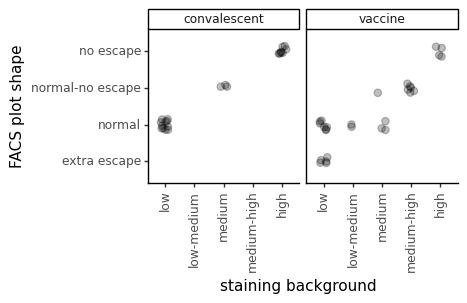

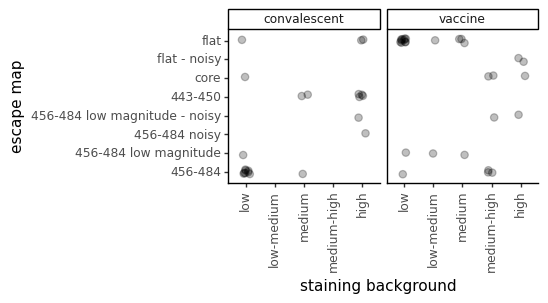

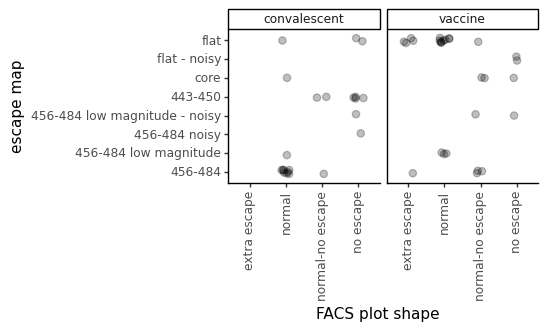

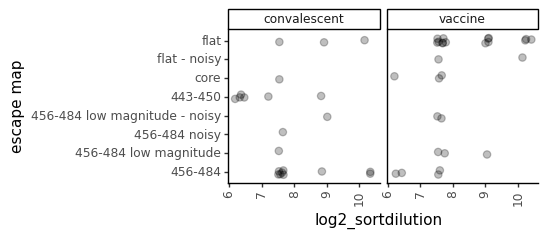

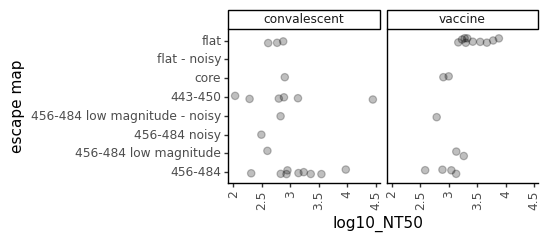

In [7]:
params=[('staining background', 'FACS plot shape'),
        ('staining background', 'escape map'),
        ('FACS plot shape', 'escape map'),
        ('log2_sortdilution', 'escape map'),
        ('log10_NT50', 'escape map'),
       ]

for (x,y) in params:
    p = (ggplot(metadata) +
         aes(x, y) +
         geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(4,2),
              )+
         facet_wrap('~sample_type')
         )

    _ = p.draw()

    # plotfile = f'{resultsdir}/all_neuts_IC50.pdf'
    # print(f"Saving to {plotfile}")
    # p.save(plotfile, verbose=False)

/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.


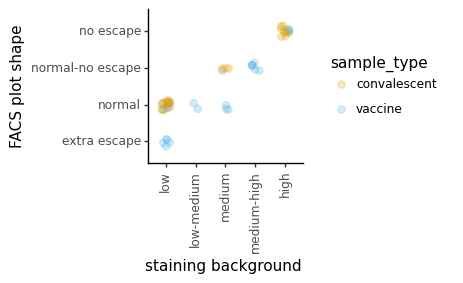

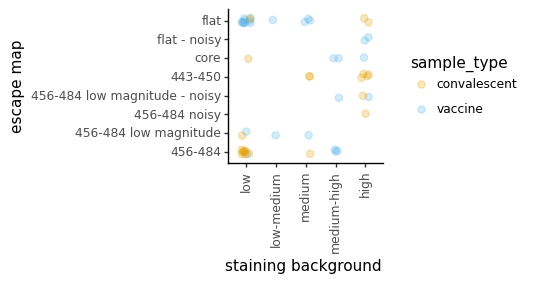

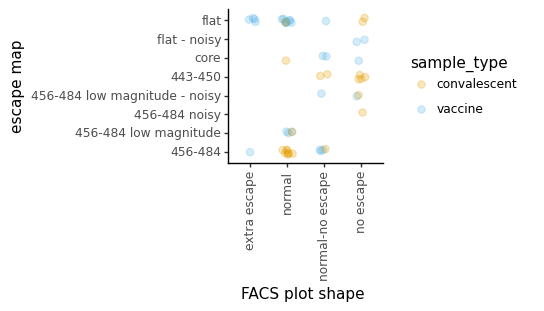

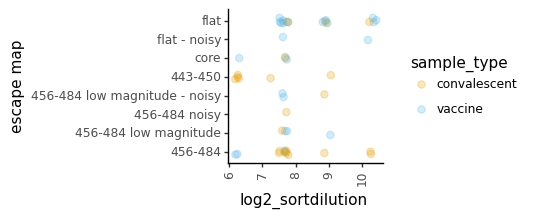

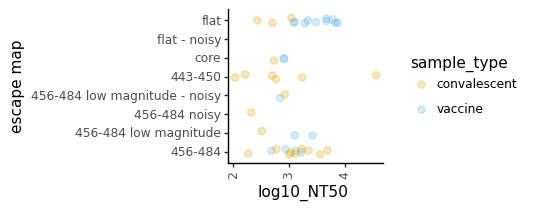

In [8]:
for (x,y) in params:
    p = (ggplot(metadata) +
         aes(x, y, color='sample_type') +
         geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(2,2),
              )+
         scale_color_manual(values=CBPALETTE[1:])
         )

    _ = p.draw()

    # plotfile = f'{resultsdir}/all_neuts_IC50.pdf'
    # print(f"Saving to {plotfile}")
    # p.save(plotfile, verbose=False)

In [9]:
svgs = []
plot_n = 0

for (x,y), n in zip(params, range(len(params))):

    print(f"\nMaking plot for {x} vs. {y}:")
    plot_n+=1
    
    if n < max(range(len(params))):
        p = (ggplot(metadata) +
             aes(x, y, color='sample_type') +
             geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   figure_size=(2,2),
                  )+
             scale_color_manual(values=CBPALETTE[1:], guide=False)
             )
    
    else:
        p = (ggplot(metadata) +
             aes(x, y, color='sample_type') +
             geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
             theme_classic() +
             theme(axis_text_x=element_text(angle=90),
                   figure_size=(2,2),
                  )+
             scale_color_manual(values=CBPALETTE[1:])
             )
    
    plotfile = f'./{resultsdir}/nofacet_plot{plot_n}.svg'
    svgs.append(plotfile)
    print(f"Saving to {plotfile}")
    p.save(plotfile)
    
merged_svg = os.path.join(resultsdir, 'merged.svg')
print(f"\nCombining plots into {merged_svg}:")
panel_pad = 15

fig_svgs = []
fig_width = 0
fig_height = 0
width_spacing = 0

ncol=3
nrow=math.ceil(len(svgs)/ncol)

for svg, n in zip(svgs, range(len(svgs))):
    if n<ncol:
        fig_svgs.append(svgutils.compose.SVG(svg).move(fig_width, 0))
        fig_width += panel_pad
        fig_width += svg_dim(svg, 'width')
        fig_height = max(fig_height, svg_dim(svg, 'height'))
    elif n%ncol==0:
        fig_height += panel_pad
        fig_height += svg_dim(svg, 'height')
        fig_svgs.append(svgutils.compose.SVG(svg).move(0, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad
    else:
        fig_svgs.append(svgutils.compose.SVG(svg).move(width_spacing, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad

svgutils.compose.Figure(fig_width,
                        fig_height,
                        *fig_svgs,
                        ).save(merged_svg)

display(SVG(merged_svg))


Making plot for staining background vs. FACS plot shape:
Saving to ./results/flat_profiles_results//nofacet_plot1.svg

Making plot for staining background vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot2.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot1.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot2.svg



Making plot for FACS plot shape vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot3.svg

Making plot for log2_sortdilution vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot4.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot3.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot4.svg



Making plot for log10_NT50 vs. escape map:
Saving to ./results/flat_profiles_results//nofacet_plot5.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 2 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//nofacet_plot5.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.



Combining plots into results/flat_profiles_results/merged.svg:


In [10]:
svgs = []
plot_n = 0

for (x,y), n in zip(params, range(len(params))):

    print(f"\nMaking plot for {x} vs. {y}:")
    plot_n+=1
    
    p = (ggplot(metadata) +
         aes(x, y) +
         geom_jitter(size=2.5, alpha=0.25, width=0.15, height=0.15, random_state=0) +
         theme_classic() +
         theme(axis_text_x=element_text(angle=90),
               figure_size=(4,2),
              )+
         facet_wrap('~sample_type')
         )
    
    plotfile = f'./{resultsdir}/facet_plot{plot_n}.svg'
    svgs.append(plotfile)
    print(f"Saving to {plotfile}")
    p.save(plotfile)
    
merged_svg = os.path.join(resultsdir, 'facet_merged.svg')
print(f"\nCombining plots into {merged_svg}:")
panel_pad = 15

fig_svgs = []
fig_width = 0
fig_height = 0
width_spacing = 0

ncol=3
nrow=math.ceil(len(svgs)/ncol)

for svg, n in zip(svgs, range(len(svgs))):
    if n<ncol:
        fig_svgs.append(svgutils.compose.SVG(svg).move(fig_width, 0))
        fig_width += panel_pad
        fig_width += svg_dim(svg, 'width')
        fig_height = max(fig_height, svg_dim(svg, 'height'))
    elif n%ncol==0:
        fig_height += panel_pad
        fig_height += svg_dim(svg, 'height')
        fig_svgs.append(svgutils.compose.SVG(svg).move(0, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad
    else:
        fig_svgs.append(svgutils.compose.SVG(svg).move(width_spacing, 0.5*fig_height+panel_pad))
        width_spacing += svg_dim(svg, 'width')+panel_pad

svgutils.compose.Figure(fig_width,
                        fig_height,
                        *fig_svgs,
                        ).save(merged_svg)

display(SVG(merged_svg))


Making plot for staining background vs. FACS plot shape:
Saving to ./results/flat_profiles_results//facet_plot1.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot1.svg



Making plot for staining background vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot2.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot2.svg



Making plot for FACS plot shape vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot3.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot3.svg



Making plot for log2_sortdilution vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot4.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot4.svg



Making plot for log10_NT50 vs. escape map:
Saving to ./results/flat_profiles_results//facet_plot5.svg


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 2 in image.
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ./results/flat_profiles_results//facet_plot5.svg
/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 9 rows containing missing values.



Combining plots into results/flat_profiles_results/facet_merged.svg:


In [11]:
final_svg = os.path.join(resultsdir, 'final.svg')
svgutils.compose.Figure(fig_width,
                        fig_height*2,
                        svgutils.compose.SVG(os.path.join(resultsdir, 'merged.svg')),
                        svgutils.compose.SVG(os.path.join(resultsdir, 'facet_merged.svg')),
                        ).tile(1,2).save(final_svg)

display(SVG(final_svg))

In [12]:
!jupyter nbconvert flat_profiles.ipynb --to HTML

[NbConvertApp] Converting notebook flat_profiles.ipynb to HTML
[NbConvertApp] Writing 2453941 bytes to flat_profiles.html
